In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid19-radiography-dataset/metadata.csv
/kaggle/input/covid19-radiography-dataset/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/Normal/Normal-859.png
/kaggle/input/covid19-radiography-dataset/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/Normal/Normal-158.png
/kaggle/input/covid19-radiography-dataset/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/Normal/Normal-10121.png
/kaggle/input/covid19-radiography-dataset/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/Normal/Normal-1811.png
/kaggle/input/covid19-radiography-dataset/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/Normal/Normal-97.png
/kaggle/input/covid19-radiography-dataset/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/Normal/Normal-1088.png
/kaggle/input/covid19-radiography-dataset/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/Normal/Normal-5663.png
/kaggle/input/covid19-radiography-dataset/COVID-19_Radiography_Dataset/COVID-19_Radiogr

In [2]:
import pandas as pd
import numpy as np
from tensorflow import keras 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
data = '/kaggle/input/covid19-radiography-dataset/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset'

In [4]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
            data,
            validation_split=0.2,
            subset="training",
            seed=123,
            image_size=(224,224),
            batch_size=32
    )

test_data = tf.keras.preprocessing.image_dataset_from_directory(
            data,
            validation_split=0.2,
            subset="validation",
            seed=123,
            image_size=(224,224),
            batch_size=32
    )

Found 21165 files belonging to 4 classes.
Using 16932 files for training.
Found 21165 files belonging to 4 classes.
Using 4233 files for validation.


In [5]:
class_names = train_data.class_names
class_names

['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

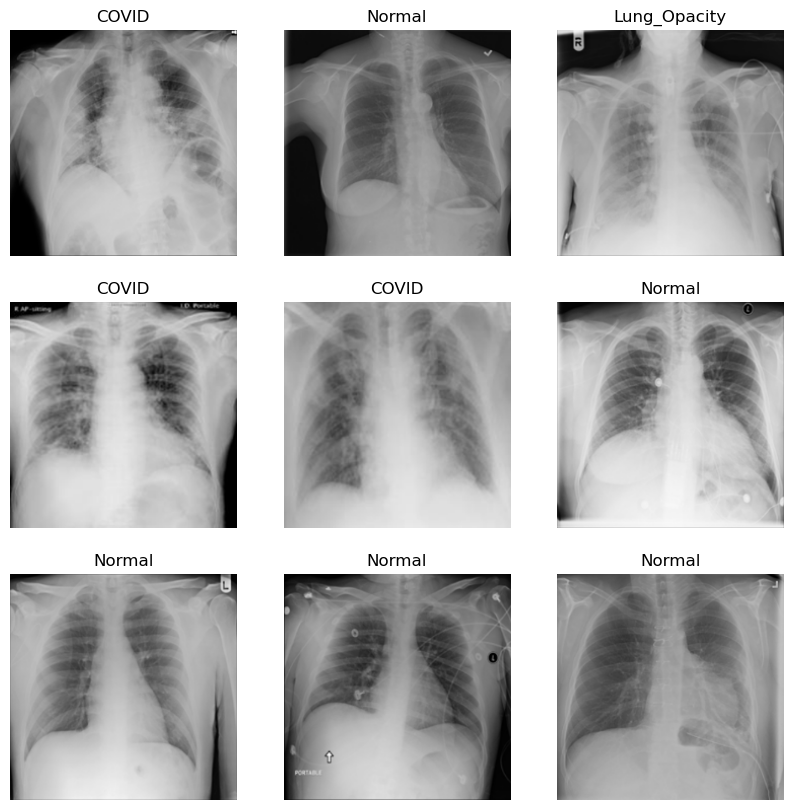

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
      ax = plt.subplot(3, 3, i+1)
      plt.imshow(images[i].numpy().astype('uint8'))
      plt.title(class_names[labels[i]])
      plt.axis('off')

In [7]:
base_model = keras.applications.ResNet50(input_shape=(224,224,3),
                                         classes=400,
                                         include_top=False,
                                         weights='imagenet')

94765736/94765736 [==============================] - 1s 0us/step


In [8]:
base_model.trainable = False
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [9]:
data_augmentation = keras.models.Sequential([
    keras.layers.RandomFlip('horizontal'),
    keras.layers.RandomRotation(0.2)
])

In [10]:
num_classes = len(class_name)
inputs = keras.Input(shape=(224,224,3))

x = data_augmentation(inputs)
# x = keras.applications.ResNet50.preprocess_input(inputs)
x = tf.keras.applications.resnet50.preprocess_input(inputs)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)

outputs = keras.layers.Dense(num_classes,activation='softmax')(x)
model = keras.Model(inputs, outputs)

NameError: name 'class_name' is not defined

In [ ]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
model.summary()

In [ ]:
initial_epochs = 10

early = EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=1, verbose=1, mode='auto')

In [ ]:
history = model.fit(train_data,
                   validation_data=test_data,
                   epochs=initial_epochs,
                   callbacks=early)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_data)
print("Test Accuracy: ", test_acc)
print("Test Loss: ", test_loss)

In [ ]:
plt.figure(figsize=(10, 100))
for images, labels in test_data.take(1):
  prediction = model.predict(images,batch_size=32)
  for i in range(9):
    ax = plt.subplot(9, 1, i+1)
    pred = np.argmax(prediction[i])
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(f'Predition: {class_names[pred]} - Real: {class_names[labels[i].numpy()]}')
    plt.axis('off')
#Visualize